## Week2. Optimization Problems & Rydberg Atom Arrays - Additional Challenge 2

-----

Here, we share the result for the solution of UD-MIS problem with QAOA approach.
The corresponding Julia/Yao script is in `run_qoao.jl`. The outer optimization loop are described here.

We didn't solve MIS problems for larger graphs, as we need to tune the hyper parameters and it is kind of burdensome.

In [1]:
from collections import Counter
from scipy.optimize import minimize
import numpy as np

from Week2_Rydberg_Atoms.draw_graph import draw_graph, draw_multi_graph, draw_distributions
from Week2_Rydberg_Atoms.julia_run_qaoa import run_qaoa_circuit, measure, convert_edges, get_edges

/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


Defining the UD-MIS problem as below

In [2]:
from Week2_Rydberg_Atoms.utils import sanity_check, int_to_bin, int_to_bin_str

graph = [(0.3461717838632017, 1.4984640297338632),
         (0.6316400411846113, 2.5754677320579895),
         (1.3906262250927481, 2.164978861396621),
         (0.66436005100802, 0.6717919819739032),
         (0.8663329771713457, 3.3876341010035995),
         (1.1643107343501296, 1.0823066243402013)
         ]
num_vertices = 6
edges = get_edges(graph)

Define the number of parameters $( \vec{\beta}, \vec{\gamma} )$ and the penalty in the cost function.
The cost function is defined as below.

$ cost = \sum_{b \in O} Pr[b] (\lambda N_v(b) - N(b)) $

, where $b$ is a bitstring in the observation, $O$ and $N_v(b)$ is the number of violated edges of which vertices corresponding to
the bitstring $b$, $N(b)$ is the number of selected vertices in $b$ and $\lambda$ is a constant for the panelty.

In [11]:
num_params = 6
panelty = 1.0
num_shots = 10000

x0 = [1.0 for _ in range(num_params)]

def cost(param, *args):
    _graph = args[0]
    _edges = args[1]
    psi = run_qaoa_circuit(num_vertices=num_vertices,
                           edges=_edges,
                           durations=param,
                           dt=0.0001)
    samples = [s for s in measure(psi, nshots=num_shots)]
    occurrence = Counter(samples)
    _cost = 0
    for k in occurrence:
        violated, num_sel = sanity_check(coordinates=_graph,
                                         answer=int_to_bin(k, num_vertices),
                                         edges=convert_edges(_edges))
        _cost += (violated * panelty - num_sel) * occurrence[k] / num_shots
    return _cost

Before running the optimization, we check the how the quantum state from the initial guess looks like.


In [12]:
initial_psi = run_qaoa_circuit(num_vertices=num_vertices, edges=edges, durations=x0, dt=0.0001)
initial_samples = [s for s in measure(initial_psi, nshots=num_shots)]
initial_occurrence = Counter(initial_samples)
initial_max_occ = sorted([k for k in initial_occurrence], key=lambda k: initial_occurrence[k], reverse=True)
print(initial_occurrence)
violated = 0
suboptimal = 0
optimal = 0
max_finding = 3
str_list = list()
sanity_list = list()
for a in initial_max_occ:
    a_bin = int_to_bin(a, num_vertices)
    a_bin_str = int_to_bin_str(a, num_vertices)
    v, n = sanity_check(graph, radius=0.5, answer=a_bin)
    str_list.append((a_bin_str, initial_occurrence[a]))
    if v > 0:
        violated += initial_occurrence[a]
        sanity_list.append(False)
    elif v == 0 and n < max_finding:
        suboptimal += initial_occurrence[a]
        sanity_list.append(False)
    elif v == 0 and n == max_finding:
        optimal += initial_occurrence[a]
        sanity_list.append(True)
    else:
        print("unexpected")
        print(v, n, max_finding)
        raise RuntimeError
print(f"probability to find obtimal answers    : {optimal/num_shots}")
print(f"probability to find invalid answers    : {violated/num_shots}")
print(f"probability to find suboptimal answers : {suboptimal/num_shots}")

Counter({63: 1487, 57: 1249, 45: 1155, 41: 673, 61: 549, 22: 423, 43: 376, 4: 339, 16: 334, 59: 277, 47: 246, 0: 227, 55: 181, 62: 174, 31: 174, 37: 170, 20: 167, 56: 161, 13: 147, 25: 141, 44: 133, 49: 132, 2: 117, 9: 85, 40: 83, 6: 81, 53: 78, 18: 77, 60: 75, 33: 62, 42: 59, 29: 57, 35: 53, 11: 40, 27: 40, 46: 36, 51: 35, 58: 35, 39: 30, 15: 20, 5: 3, 24: 3, 54: 3, 23: 2, 30: 2, 48: 1, 1: 1, 14: 1, 12: 1, 3: 1, 19: 1, 52: 1, 17: 1, 34: 1})
probability to find obtimal answers    : 0.0001
probability to find invalid answers    : 0.8803
probability to find suboptimal answers : 0.1196


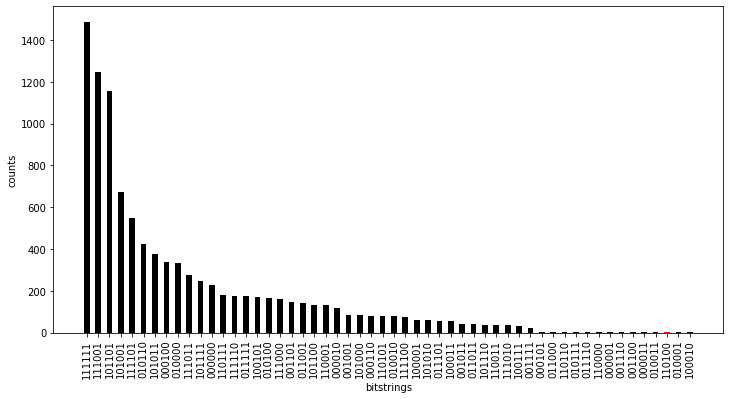

In [13]:
draw_distributions(str_list, sanity_list)

Now we run the optimization loop to find the quantum state minimizing the cost.

In [4]:
opt_res = minimize(cost,
                   args=(graph, edges),
                   x0=np.array(x0),
                   method="Powell",
                   tol=1e-5)
print(opt_res)

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.97161107e-07,  2.04691319e-07, -2.48413415e-07,
        -9.81166378e-08,  3.34121179e-07, -1.78160439e-07]])
     fun: array(-2.3614)
 message: 'Optimization terminated successfully.'
    nfev: 1834
     nit: 7
  status: 0
 success: True
       x: array([ 0.14589906, -0.61803359,  1.00000038,  0.99988067,  0.99998495,
        0.99999948])


Plot the most frequent bitstrings after the optimization.

Counter({28: 1452, 21: 1406, 52: 1398, 20: 472, 30: 370, 10: 370, 23: 360, 54: 352, 3: 322, 34: 322, 36: 317, 24: 284, 12: 281, 5: 278, 17: 274, 48: 257, 61: 144, 22: 136, 26: 127, 4: 112, 16: 109, 2: 107, 14: 103, 19: 102, 7: 89, 50: 88, 38: 83, 63: 40, 18: 40, 6: 36, 43: 33, 57: 29, 45: 21, 60: 13, 1: 11, 47: 10, 59: 9, 53: 9, 29: 6, 8: 4, 13: 3, 42: 3, 32: 3, 0: 2, 49: 2, 35: 2, 27: 2, 37: 2, 62: 1, 40: 1, 44: 1, 55: 1, 56: 1})


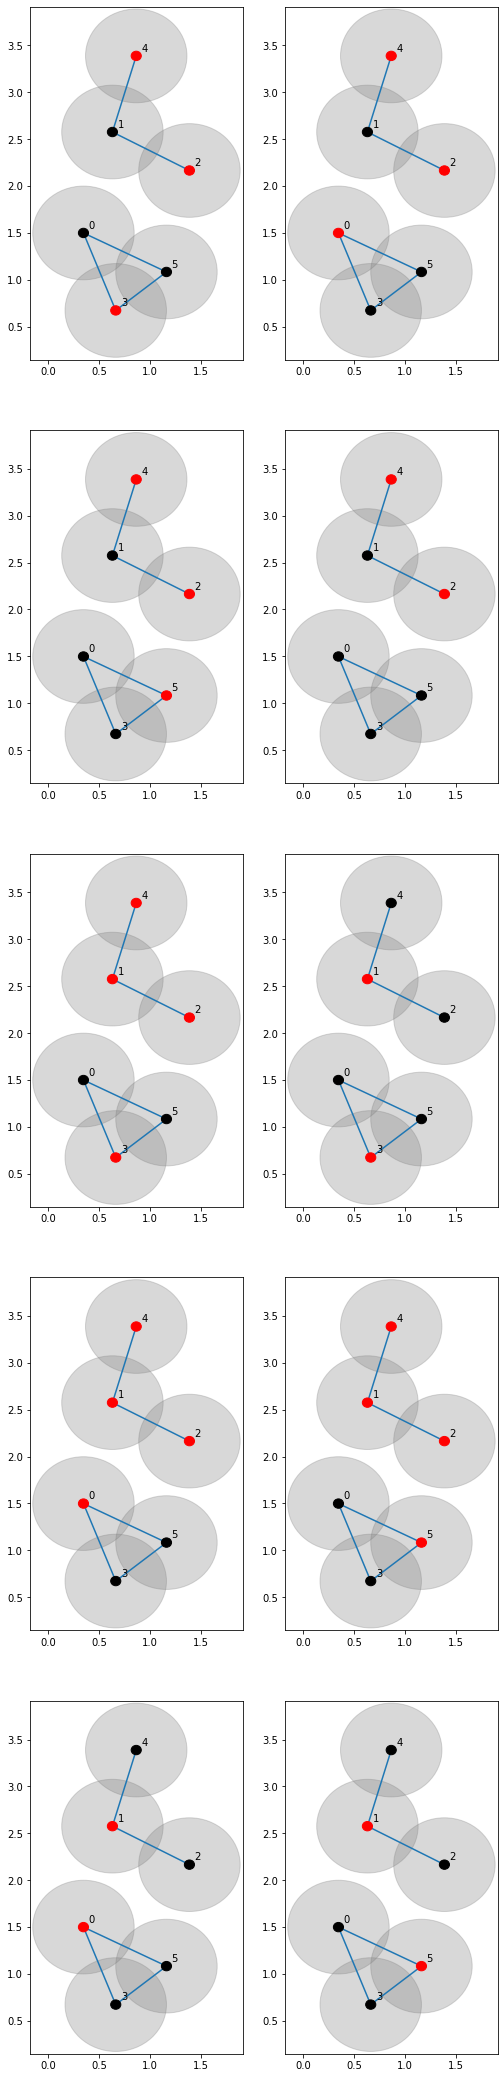

In [5]:
opt_param = opt_res.x
opt_psi = run_qaoa_circuit(num_vertices=num_vertices, edges=edges, durations=opt_param, dt=0.0001)
opt_samples = [s for s in measure(opt_psi, nshots=num_shots)]
opt_occurrence = Counter(opt_samples)
opt_max_occ = sorted([k for k in opt_occurrence], key=lambda k: opt_occurrence[k], reverse=True)
print(opt_occurrence)
draw_multi_graph(graph,
                 radius=0.5,
                 answer_list=[int_to_bin(m, num_vertices)for m in opt_max_occ][:10])

In [8]:
violated = 0
suboptimal = 0
optimal = 0
max_finding = 3
str_list = list()
sanity_list = list()
for a in opt_max_occ:
    a_bin = int_to_bin(a, num_vertices)
    a_bin_str = int_to_bin_str(a, num_vertices)
    v, n = sanity_check(graph, radius=0.5, answer=a_bin)
    str_list.append((a_bin_str, opt_occurrence[a]))
    if v > 0:
        violated += opt_occurrence[a]
        sanity_list.append(False)
    elif v == 0 and n < max_finding:
        suboptimal += opt_occurrence[a]
        sanity_list.append(False)
    elif v == 0 and n == max_finding:
        optimal += opt_occurrence[a]
        sanity_list.append(True)
    else:
        print("unexpected")
        print(v, n, max_finding)
        raise RuntimeError
print(f"probability to find obtimal answers    : {optimal/num_shots}")
print(f"probability to find invalid answers    : {violated/num_shots}")
print(f"probability to find suboptimal answers : {suboptimal/num_shots}")

probability to find obtimal answers    : 0.4256
probability to find invalid answers    : 0.2219
probability to find suboptimal answers : 0.3525


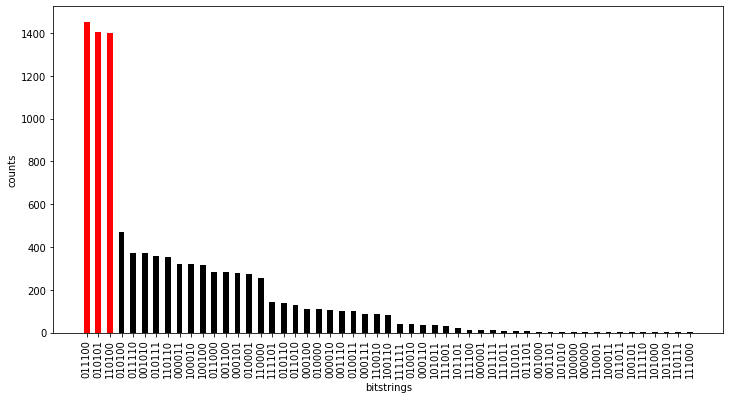

In [9]:
draw_distributions(str_list, sanity_list)